## Introduction

In recent decades, central bank communications have not only become a crucial tool for shaping economic expectations and outcomes. Effective communication enables central banks to influence financial markets, enhance monetary policy predictability and achieve macroeconomic goals [@blinder2008]. Research indicates that policy announcements are pivotal for the implementation of monetary policy [@guthrie2000] and offer insights into future policy directions [@gurkaynak2005]. As Bernanke [-@bernanke2015] noted, communication stands as one of the most powerful instruments at central banks’ disposal, highlighting the significant risks associated with miscommunication. This critical role of communication has spurred growing interest in understanding and analyzing central bank messaging. Coupled with advancements in Natural Language Processing (NLP) and computational power, this interest has driven the application of various NLP techniques to study central bank texts [@bholat2015]. In particular, the literature on sentiment analysis commonly employs two main approaches: dictionary-based and machine learning methods [@algaba2020]. Dictionary-based methods rely on predefined sets of n-grams to determine sentiment based on the frequency of positive and negative terms, with popular examples including the dictionaries by Loughran and McDonald [-@loughran2011] and Apel and Grimaldi [-@apel2014]. Conversely, machine learning methods, particularly supervised learning techniques such as Naive Bayes, classify sentiment by learning from a pre-labeled corpus and then applying this knowledge to new, unseen communications. While both approaches have their strengths and weaknesses, as highlighted by Frankel et al. [-@frankel2022], the adoption of supervised learning is less prevalent. This is likely due to the time-consuming effort and expertise required to construct a pre-labeled dataset. Additionally, the supervised learning literature is limited in the variety and size of corpora used, indicating a need for further empirical evidence across diverse scenarios and central banks, especially as much of the existing research focuses on developed economies, leaving emerging markets less represented. To address these gaps, this study employs supervised machine learning techniques in Python to classify the sentiment of press releases from the Bank of Thailand, focusing on the context of Thai monetary policy.

## The Dataset

The corpus comprises 794 pre-labeled sentences extracted from 26 English-language press releases issued by the Bank of Thailand. These press releases span the period from 3 February 2021 to 18 December 2024. A representative sample of the dataset is presented in Table 1.

::: {#table-1-prelabelled-dataset}

![](table-1-prelabelled-dataset.png)

Table 1: a sample of pre-labeled sentences from Bank of Thailand press releases in English.
:::

The dataset was constructed by extracting the main body text from Monetary Policy Committee (MPC) press releases in PDF format, which are publicly available on the Thai Central Bank website [@bot_press_statement]. The extracted text was split into sentences and sentiment-labeled using ChatGPT, followed by manual revisions by the author to ensure validation and quality assurance. While this approach combined generative AI and human expertise, it was time intensive. Additionally, challenges during annotation, such as sentences with mixed sentiment, required expert judgment, which introduced bias. While many studies represent sentiment in a binary fashion, categorizing it as either "hawkish" (positive) or "dovish" (negative),  this approach has been critiqued in the literature. Although such a classification can be useful in some contexts, associating policy stance directly with sentiment can be misleading, especially when negative words are not necessarily "hawkish" or vice versa. Therefore, this study opts for a more straightforward approach in representing sentiment, avoiding associations with policy stances.

In [109]:
# Import libraries for loading the dataset
import os
import re
import pandas as pd
import numpy as np

# Load dataset
bot_prelabeled_sent = pd.read_csv('./bot_annotated_sentences.csv')

# Show info
bot_prelabeled_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       794 non-null    object
 1   sentiment  794 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.5+ KB


Figure 1 illustrates the distribution of sentiment classes. The minority class, negative sentiment, accounts for 21.3% of the total dataset. Although the corpus is predominantly positive and neutral, the dataset is not considered highly imbalanced. As such, imbalanced dataset techniques are not deemed necessary for this study.

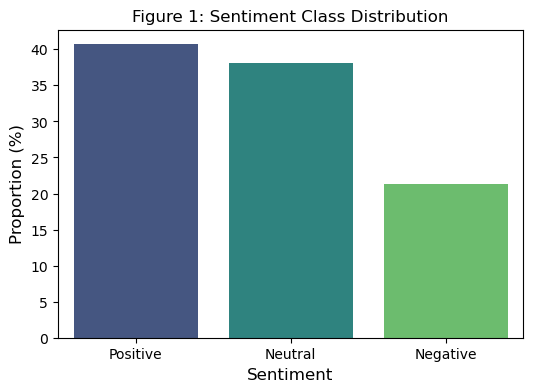

In [7]:
#| warning: false
#| echo: false

# Import libraries for plotting the class distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Map sentiment labels
sentiment_values = bot_prelabeled_sent['sentiment'].map({1: 'Positive', 
                                                         0: 'Neutral', 
                                                         -1: 'Negative'})

# Count the occurrences of each category directly from the mapped values
category_counts = sentiment_values.value_counts()

# Calculate percentages for each category
total = category_counts.sum()
category_percentages = (category_counts / total) * 100

# Create a DataFrame for plotting
plot_data = category_counts.reset_index()
plot_data.columns = ['Sentiment', 'Count']
plot_data['Percentage'] = (plot_data['Count'] / plot_data['Count'].sum()) * 100

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Sentiment', y='Percentage', data=plot_data, 
            palette='viridis', hue='Sentiment')
plt.title('Figure 1: Sentiment Class Distribution', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.show();

Detailed information on the dataset preparation and labeling methodology can be found in Appendices A and B.

## Objective

The primary objective of this study is to classify the sentiment (negative, neutral, positive) of English Thai central bank press releases using three commonly used supervised machine learning techniques: Naive Bayes [@li2010], Support Vector Machines [@mullen2004] and Random Forest [@frankel2022].

This paper contributes to the literature by:

1. **Expanding the application of machine-learning methods in central bank communication**: while existing research predominantly relies on lexicon-based methods, few studies explore supervised machine learning approaches due to challenges such as the lack of labeled datasets. This study aims to address this gap and provide robust evidence of the effectiveness of data-driven methods in sentiment classification.
2. **Increasing relevance to modern data environments**: in the era of Big Data, the adoption of NLP techniques by central banks, financial institutions and policymakers is increasingly important. These methods not only allow for the automated analysis of large volumes of textual data but also offer downstream applications, such as improving econometric models and leveraging sentiment features for time series analysis. This research highlights the practical benefits of integrating sentiment analysis into decision-making processes.
3. **Filling the gap in emerging market research**: much of the literature on central bank communication centers on developed economies, leaving emerging markets less explored. By focusing on the Bank of Thailand, this work offers additional valuable insights into the classification of central bank communications in the context of a developing economy.

## Evaluation Methodology

The evaluation of the three proposed sentiment classifiers is based on the following metrics:

- Precision
- Recall
- F1 Score
- Macro-Precision
- Macro-Recall
- Macro-F1 Score

These metrics are chosen for two primary reasons. First, precision and recall are standard in NLP tasks. Precision measures the proportion of correctly predicted positive instances out of all predicted positives, while recall assesses the proportion of actual positives correctly identified. The F1 score, which is the harmonic mean of precision and recall, balances the trade-off between these metrics. This is particularly useful when the distribution of sentiment classes is uneven. Second, the use of these metrics is supported by their established application in previous research on central bank communications, such as the study by Pfeifer and Marohl [-@pfeifer2023]. Although their study utilized a binary classification methodology with a different dataset composition and size, their findings provide a relevant point of reference for this research. Since this study involves multinomial sentiment classification, macroaveraging is employed. Macroaveraging calculates the metrics independently for each class and then averages them, making it more sensitive to the performance of smaller classes [@jurafsky2024]. These metrics are reported both per class and as a macro average. Additionally, the models are fine-tuned to enhance performance using the Macro-F1 score. This fine-tuning process, which includes hyperparameter optimization and validation strategies, is further elaborated  in the following sections. This approach is particularly appropriate when all classes are equally important, as is the case here, given the imbalanced characteristic of the dataset.

## Preprocessing

The dataset is first split into 80% training (635) and 20% testing (159) sets in a stratified manner.

In [13]:
# Import library for splitting
from sklearn.model_selection import train_test_split

# Prepare Dataset for splitting
X = bot_prelabeled_sent['text'].values 
y = bot_prelabeled_sent['sentiment'].values 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=42, # for reproducibility
    shuffle=True,
    stratify=y # to ensure classes are split appropriately
   )
# Print statement
print('Data is split into 80% train and 20% test sets.')

Data is split into 80% train and 20% test sets.


Then, the text is preprocessed using a custom tokenizer combined with the scikit-learn  `TfidfVectorizer` for feature extraction [@scikit-learn], a standard approach in machine learning methods. The tokenizer captures words, numbers and hyphenated terms, applies lemmatization using `WordNetLemmatizer` from NLTK [@bird2009] to reduce words to their base forms and removes common English stop words (e.g., "the", "a") to reduce dimensionality and speed up computation. The `TfidfVectorizer` transforms the text into numerical features using Term Frequency-Inverse Document Frequency (TF-IDF), which is a numerical measure that indicates the significance of a word within a document relative to a collection or corpus [@manning2008], capturing the importance of n-grams (unigrams, bigrams and trigrams) while accounting for term presence/absence and lowercasing to ensure consistency.

In [16]:
# Import libraries for preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer


# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a custom tokenizer
def custom_tokenizer(text):
    """
    Tokenizes the input text by extracting words, numbers, 
    hyphenated terms and applying lemmatization to reduce 
    words to their base forms.
    
    Args:
    text (str): The input text to be tokenized.

    Returns:
    list: A list of lemmatized tokens after removing common 
    English stop words.
    
    The function uses regular expressions to capture words, 
    floating-point numbers and integers, then applies 
    lemmatization using WordNetLemmatizer from NLTK.
    It also removes stop words to reduce dimensionality 
    and improve computation speed.
    """
    # Capture words, floating-point numbers and integers
    tokens = re.findall(r'\b\d+\.\d+|\b\d+|\b\w+(?:-\w+)?\b', text)
    
    # Remove stop words and apply lemmatization
    return [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token.lower() not in ENGLISH_STOP_WORDS
    ]

# Apply TF-IDF vectorization
tf_idf = TfidfVectorizer(
    ngram_range=(1, 3),  # Use unigrams, bigrams and trigrams
    binary=True,         # presence/absence of words
    smooth_idf=False,    # Disable smoothing of idf
    lowercase=True,      # Ensure all text is converted to lowercase
    token_pattern=None,  # Explicitly allow custom tokenizer
    tokenizer=custom_tokenizer  # Use custom tokenizer
)

# Fit and transform the training data, and transform the testing data
X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

### Baseline Performance

Among the three classifiers selected for this study, Naive Bayes serves as the baseline. It is a widely used method in NLP sentiment classification tasks due to its simplicity, making it a natural choice for comparison.

## Classification Approach

The classifiers are implemented using the scikit-learn library and are fine-tuned to optimize the Macro-F1 score through grid search with 5-fold cross-validation [@james2013]. The selection of the hyperparameters takes was based on several tests run on a Mac M1 hardware.

### Naive Bayes

Naive Bayes has a single hyperparameter, `alpha`, which is used for Laplace smoothing to address the issue of zero probability when a new observation appears in the query data [@analyticsvidhya2021].

In [20]:
# Import Grid Search CV 
from sklearn.model_selection import GridSearchCV

# Import NB model
from sklearn.naive_bayes import MultinomialNB

# Define the model
nb_model = MultinomialNB()

# Define the parameter grid for alpha values
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]}

# Perform GridSearchCV with 5-fold cross-validation and macro F1 score
grid_search = GridSearchCV(nb_model, 
                           param_grid, 
                           scoring='f1_macro', cv=5)

# Fit the Naive Bayes Model model
grid_search.fit(X_train_tfidf, y_train)

# Best hyperparameter value for alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha (based on Macro-F1 score): {best_alpha}")

# Fit the NB model
best_nb_model = MultinomialNB(alpha=best_alpha)
best_nb_model = best_nb_model.fit(X_train_tfidf, y_train)

Best alpha (based on Macro-F1 score): 0.1


### Support Vector Machines

The key hyperparameters of Support Vector Machines (SVMs) are `C` (regularization parameter), `gamma` (kernel coefficient, influencing the decision boundary) and `kernel` (type of function to map data, such as `linear`, `rbf` or `poly`).

In [22]:
# Import SVM model and related libraries
from sklearn import svm, model_selection

# Define SVM classifier and parameters
svm_clf = svm.SVC(probability=True)

# Hyperparameter tuning with GridSearchCV, 
# scoring based on macro-F1 score
parameters = {
    'C': [0.1, 1, 10], # regularization parameter
    'kernel': ['linear', 'rbf', 'poly'], # type of function to map data
    'gamma': [0.01, 0.1, 0.5] # kernel coefficient
} 

grid_svm_clf = model_selection.GridSearchCV(estimator=svm_clf, 
                                            param_grid=parameters, 
                                            scoring='f1_macro', cv=5)

# Fit the grid search to the training data
grid_svm_clf.fit(X_train_tfidf, y_train)

# Best hyperparameter combination based on macro F1 score
best_params = grid_svm_clf.best_params_
print(f"Best parameters (based on Macro-F1 score):\n{best_params}")

# Get Best SVM Model
best_svm_model = grid_svm_clf.best_estimator_

Best parameters (based on Macro-F1 score):
{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}


### Random Forest

The key hyperparameters of Random Forest are `n_estimators` (number of trees), `max_depth` (maximum depth of trees), `min_samples_split` (minimum samples required to split a node) and `max_features` (maximum number of features to consider for splitting).

In [26]:
# Import Random Forest
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Hyperparameter grid with a reduced search space
parameters = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
}

# Apply GridSearchCV 
grid_rf_clf = GridSearchCV(rf_clf, param_grid=parameters, cv=5, 
                           scoring='f1_macro', n_jobs=-1)

# Fit the grid search 
grid_rf_clf.fit(X_train_tfidf, y_train)

# Get the best parameters
best_params = grid_rf_clf.best_params_

# Print the best parameters
print("Best parameters (based on Macro-F1 score):\n"
      f"max_depth: {best_params['max_depth']},\n"
      f"max_features: {best_params['max_features']},\n"
      f"min_samples_split: {best_params['min_samples_split']},\n"
      f"n_estimators: {best_params['n_estimators']}")

# Get best RF Model
best_rf_model = grid_rf_clf.best_estimator_

Best parameters (based on Macro-F1 score):
max_depth: 30,
max_features: sqrt,
min_samples_split: 2,
n_estimators: 100


## Evaluation

The performance of the three classifiers summarised in Table 2, reveals insights in concordance with the literature on sentiment classification. Naive Bayes outperforms both Random Forest and SVM with a Macro-F1 score of 0.75, compared to SVM’s 0.71 and Random Forest’s 0.62. This indicates that NB provides the most balanced performance across all classes. Notably, the relatively small sample size likely contributes to these results, as more data would enable the more complex models like Random Forest and SVM to outperform Naive Bayes, as seen in other studies.

In [38]:
# Import Classification Report from sklearn
from sklearn.metrics import classification_report

# Define the target names (sentiment classes)
target_names = ['Negative', 'Neutral', 'Positive']

# Get the predictions for the test set
y_pred_rf = best_rf_model.predict(X_test_tfidf)
y_pred_svm = best_svm_model.predict(X_test_tfidf)
y_pred_nb = best_nb_model.predict(X_test_tfidf)

# Get classification report for each model
report_rf = classification_report(y_test, y_pred_rf, 
                                  target_names=target_names, 
                                  output_dict=True)
report_svm = classification_report(y_test, y_pred_svm, 
                                   target_names=target_names, 
                                   output_dict=True)
report_nb = classification_report(y_test, y_pred_nb, 
                                  target_names=target_names, 
                                  output_dict=True)

# Create DataFrames for class-wise metrics
df_rf = pd.DataFrame(report_rf).transpose()
df_svm = pd.DataFrame(report_svm).transpose()
df_nb = pd.DataFrame(report_nb).transpose()

# Select metrics to report for each classifier
df_rf = df_rf[['precision', 
               'recall', 
               'f1-score']].drop(['accuracy', 
                                  'weighted avg']).round(2)
df_svm = df_svm[['precision', 
                 'recall', 
                 'f1-score']].drop(['accuracy', 
                                    'weighted avg']).round(2)
df_nb = df_nb[['precision', 
               'recall', 
               'f1-score']].drop(['accuracy', 
                                  'weighted avg']).round(2)


# List of dataframes and corresponding model names
models_df = [df_rf, df_svm, df_nb]

# Initialize an empty list to store the final result
final_data = []

# Loop through each model's dataframe
for df in models_df:
    # Add a header row for the model name spanning columns
    header_row = pd.DataFrame([['', '', '']], columns=df.columns)
    
    # Concatenate: header row and the dataframe
    final_data.append(header_row)
    final_data.append(df.reset_index())

# Concatenate all dataframes
final_df = pd.concat(final_data, ignore_index=True)

# Manually assign model names to specific rows using iloc
final_df.iloc[0, 3] = 'Random Forest'  
final_df.iloc[5, 3] = 'SVM'           
final_df.iloc[10, 3] = 'Naive Bayes'  

# Reorder columns to put 'index' first
final_df = final_df[['index'] + 
                     [col for col in final_df.columns if col != 'index']]


# Fill NaN values with empty strings for markdown compatibility
final_df.fillna('', inplace=True)

# Rename 'index' column to empty for markdown
final_df.rename(columns={'index': ''}, inplace=True)

In [40]:
#| warning: false
#| echo: false

# Display the caption and table without the index
from IPython.display import display, Markdown

# Caption for the table
caption = "Table 2: Comparison of Model Performance Metrics"
table_markdown = final_df.to_markdown(index=False)

# Display Caption and Table
display(Markdown(f"{table_markdown}\n\n{caption}"))

**Table 2: Comparison of Model Performance Metrics**

|               | precision   | recall   | f1-score   |
|:--------------|:------------|:---------|:-----------|
| Random Forest |             |          |            |
| Negative      | 0.65        | 0.44     | 0.53       |
| Neutral       | 0.68        | 0.63     | 0.66       |
| Positive      | 0.61        | 0.75     | 0.68       |
| macro avg     | 0.65        | 0.61     | 0.62       |
| SVM           |             |          |            |
| Negative      | 0.71        | 0.71     | 0.71       |
| Neutral       | 0.66        | 0.68     | 0.67       |
| Positive      | 0.78        | 0.75     | 0.77       |
| macro avg     | 0.71        | 0.71     | 0.71       |
| Naive Bayes   |             |          |            |
| Negative      | 0.69        | 0.79     | 0.74       |
| Neutral       | 0.75        | 0.68     | 0.71       |
| Positive      | 0.78        | 0.78     | 0.78       |
| macro avg     | 0.74        | 0.75     | 0.75       |

## Conclusion

The primary objective of this study is to classify the sentiment of central bank communications using the English press releases of the Bank of Thailand and supervised learning techniques. These techniques demonstrates their value in automating sentiment analysis, capturing linguistic nuances and providing more objective metrics and baselines to counterbalance the limitations of dictionary-based methods. Furthermore, the emergence of advanced NLP models, such as large language models (LLMs), suggests the potential for richer interpretations of central bank communications [@alonso2023; @pfeifer2023]. In the context of Thailand, future research could focus on expanding the English-language corpus to include additional press releases, thereby enhancing classifier performance. Another avenue of research could explore less-studied machine learning methods, address issues related to imbalanced data and contribute to the refinement of labeling methodologies, building upon the approach outlined in Appendix B. Additionally, research could focus on classifying press releases in Thai, addressing language-specific challenges and applying machine learning techniques to develop an effective sentiment classification model for Thai texts. Despite these advancements, several operational challenges were encountered, including dataset acquisition, preprocessing and labeling. While generative AI and the relatively small size of the corpus facilitated some steps, the process remained time-intensive and required human expertise, introducing the risk of bias, aligning with existing claims. To support research efforts, this paper recommends that central banks, such as the Bank of Thailand, enhance accessibility by providing APIs for retrieving textual data and maintaining comprehensive archives of past communications. In conclusion, supervised learning approaches, including simple models like Naive Bayes, offer a promising starting point for sentiment analysis, even with limited data. By overcoming the challenge of constructing a dataset, they provide a foundation for exploring more sophisticated models as the field continues to evolve, effectively complementing dictionary-based methods and underline the value of machine learning techniques for quantifying sentiment in central bank communications within today’s data-driven era.

## References

::: {#refs}
:::

## Appendix A: Extracting and Cleaning Text from MPC Press Releases PDFs

The process of extracting and cleaning raw text from PDF files is implemented to ensure the data is well-structured and free from irrelevant content. Text is extracted using the pdfminer library, and subsequently cleaned through a series of steps. This includes removing unwanted elements such as emails, phone numbers, headers, footers and decision identifiers. Additional refinements address issues like hyphenation across line breaks, redundant spaces, and page numbers. The cleaned text is structured into a DataFrame, with each document assigned a unique identifier for further analysis.

In [ ]:
## Import function used for extracting text from MPC press releases PDFs
from pdfminer.high_level import extract_text

# Step 1: function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    """
    Extracts text from a PDF file using pdfminer.
    """
    try:
        return extract_text(pdf_path)
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
        return None

# Step 2: function to clean the extracted text
def clean_extracted_text(text):
    """
    Cleans the extracted text by removing unwanted content, 
    such as emails, phone numbers,Bank of Thailand footer, 
    Press Conference, reference numbers, decision identifiers
    and extra spaces.
    """
    # Remove 'Press Conference' section
    text = re.sub(r'Press Conference.*', '', text, flags=re.DOTALL)

    # Remove contact information (emails and phone numbers)
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'\+?\d[\d -]{8,}\d', '', text) # Remove phone numbers

    # Remove specific sections related to Bank of Thailand 
    # and incomplete footers
    footer_pattern = (
     r'(Bank of Thailand\s*\d{1,2}\s*\w+\s*\d{4})'
     r'(.*?(Tel.*?|E-?mail:.*?|Monetary Policy Strategy Division.*?))?'
     r'[\s]*'
    )
    text = re.sub(footer_pattern, '', 
                  text, flags=re.IGNORECASE | re.DOTALL)

    # Specifically remove incomplete footer lines 
    # and cases like ": , E-mail:" and "Tel"
    text = re.sub(r':\s*,?\s*E-?mail\s*:?,?\s*', '', 
                  text, flags=re.IGNORECASE)
    # Remove "Tel" with optional punctuation
    text = re.sub(r'\bTel[:\s,]*', '', 
                  text, flags=re.IGNORECASE) 

    # Remove headings and identifiers
    text = re.sub(r'No\.\s*\d+/\d+', '',
                  text)  # Remove reference numbers
    # Remove decision identifiers
    text = re.sub(r'Monetary Policy Committee’s Decision \d+/\d+', 
                  '', text)
    text = re.sub(r'Mr\.\s+\w+', '', text)  # Remove names

    # Remove extra newlines
    text = re.sub(r'\n+', '\n', text)

    # Remove page numbers associated 
    # with form feed characters (e.g., '\x0c2')
    text = re.sub(r'\x0c\d+', '', text)

    # Fix hyphenated words across line breaks
    text = re.sub(r'-\n', '', text)

    # Find "B.E." and remove punctuation
    text = re.sub(r'B\.E\.', 'BE', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Step 3: process all PDFs in the folder
def process_pdfs_in_folder(folder_path):
    """
    Processes all PDF files in a folder to extract and clean text.
    Returns a pandas DataFrame with the document ID and cleaned text.
    """
    # Initialize an empty list to hold extracted data
    data = [] 

    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(".pdf"):
            pdf_path = os.path.join(folder_path, file_name)
            # uncomment if needed
            #print(f"Processing: {pdf_path}")

            # Extract and clean text
            raw_text = extract_text_from_pdf(pdf_path)
            if raw_text:
                cleaned_text = clean_extracted_text(raw_text)
                data.append({"text": cleaned_text}) 

    # Step 4: create a DataFrame from the extracted data
    df = pd.DataFrame(data)

    # Add an 'id' column based on the index, starting from 1
    df['id'] = df.index + 1

    return df

# Process PDFs and save to a DataFrame
df = process_pdfs_in_folder(folder_path)

### A1: Preprocessing Text for Labeling

The raw text is preprocessed to facilitate labeling by segmenting documents into sentences using the NLTK library’s `sent_tokenize` method. Each sentence is associated with its document ID and assigned a placeholder for sentiment labels. To reduce potential ordering bias, the sentences are randomized. The final structured data is saved as a CSV file for annotation purposes.

In [ ]:
# Import function for splitting text into sentences 
from nltk.tokenize import sent_tokenize

# Ensure nltk resources are downloaded
nltk.download('punkt')

# Step 1: segment each document into sentences
segmented_data = []
for doc_id, text in zip(df['id'], df['document']):
    sentences = sent_tokenize(text)
    for sentence in sentences:
        segmented_data.append({
            "document_id": doc_id, #for reference if needed
            "text": sentence,
            "sentiment": None  # Placeholder for annotation
        })

# Step 2: create a new DataFrame with segmented sentences
segmented_df = pd.DataFrame(segmented_data)

# Step 3: shuffle the DataFrame to randomize the sentences
segmented_df = segmented_df.sample(frac=1).reset_index(drop=True)

# Step 4: save for annotation
segmented_df.to_csv('sentences_for_annotation.csv', index=False)

## Appendix B: Sentiment Annotation Guidelines

This appendix outlines the criteria and process used for annotating sentiment in the dataset.

### Sentiment Labels

1. **Positive (1)**:  
   * Sentences with an optimistic or favorable tone.
   * Examples:  
       - "The Committee viewed that government measures should be expedited to support the economic recovery."
       - "Growth is expected to pick up in 2024 due to steady tourism recovery and improved exports."  

2. **Negative (-1)**: 
   * Sentences with a pessimistic or unfavorable tone.
   * Examples:  
       - "Financial fragilities remain for some SMEs and households exposed to rising costs."
       - "Core inflation remains elevated, posing risks to economic stability."
  

3. **Neutral (0)**: 
   * Fact-based or descriptive sentences without evident sentiment.
   * Examples:  
       - "The document was published on 12th October."
       - "The Committee projected economic growth of 3.6% in 2023 and 3.8% in 2024."

### Annotation Process

The sentiment annotation involved a combination of automated and manual steps: 

* Initial annotations were generated using Generative AI (ChatGPT), prompted to classify sentences as positive, negative or neutral based on their tone and context.
* The author, as a domain expert, reviewed and corrected AI-generated annotations to ensure accuracy, particularly aligning labels with the economic policy context.

#### Prompt

The following prompt was used to generate sentiment annotations for the sentences:

> "Classify the sentiment of the following sentence into one of the three categories: Positive, Negative or Neutral. Provide a brief explanation for your classification."

### Quality Assurance

To maintain high-quality annotations and minimize bias:

* Sentences were reviewed for tone consistency, factoring in contextual nuances.
* Mixed sentiments were marked neutral, while ambiguous cases were carefully evaluated or defaulted to neutral as well.